<a href="https://colab.research.google.com/github/step-cheng/mnist_from_scratch/blob/main/mnist_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
from os.path import join
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [2]:
def shuffle(x,y):
  pattern = np.random.permutation(y.size)
  x, y = x[pattern,:,:], y[pattern]
  return x, y

def one_hot_encode(labels):
  one_hot = np.zeros((10,labels.size))
  one_hot[labels, range(labels.size)] = 1
  return one_hot

def normalize(data):
  data = data * (1 / 255)
  return data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = shuffle(x_train, y_train)
one_hot_Y = one_hot_encode(y_train)

img_data = np.reshape(x_train,(x_train.shape[0],784)).T
assert img_data.shape == (784,60000)
assert one_hot_Y.shape == (10,60000)

img_data = normalize(img_data)


11490434/11490434 [==============================] - 1s 0us/step


In [4]:
def show_image(img, label):
    img = np.reshape(img.T, (28,28))
    num = np.where(label == 1)
    plt.figure()
    plt.title(f'Image number: {num[0]}')
    plt.imshow(img, cmap=plt.cm.gray)


In [5]:
def initialize(dims):
  params = {}
  for i in range(1, len(dims)):
      params['W' + str(i)] = np.random.randn(dims[i], dims[i-1]) * np.sqrt(1/(dims[i]))
      params['b' + str(i)] = np.random.randn(dims[i], 1) * np.sqrt(1/dims[i])
  return params


In [6]:
def relu(Z):
  return np.maximum(Z,0)

def softmax(Z):
  Z_ = Z - np.max(Z, axis = 0, keepdims = True)
  A = np.exp(Z_) / np.sum(np.exp(Z_), axis = 0, keepdims = True)
  return A

def forward_pass(X, params):
  L = len(params)//2

  forward = {}
  forward['A0'] = X

  for i in range(1,L):
    forward['Z'+str(i)] = np.dot(params['W'+str(i)], forward['A'+str(i-1)]) + params['b'+str(i)]
    forward['A'+str(i)] = relu(forward['Z'+str(i)])

  forward['Z'+str(L)] = np.dot(params['W'+str(L)], forward['A'+str(L-1)]) + params['b'+str(L)]
  forward['A'+str(L)] = softmax(forward['Z'+str(L)])

  return forward


In [7]:
def accuracy(A, Y):
  assert A.shape == Y.shape
  pred = np.zeros_like(A)
  pred[np.argmax(A, axis = 0), range(A.shape[1])] = 1
  acc = np.count_nonzero(pred + Y == 2) / Y.shape[1]
  return acc

In [8]:
def relu_deriv(A):
  return A > 0

def softmax_crossentropy_deriv(A, Y):
  return A - Y

def back_pass(forward, params, Y):
  L = len(params) //2

  grads = {}

  # cross-entropy loss is calculated by averaging the loss over the sample size, thus the upstream gradient is 1/sample size
  N = Y.shape[1]

  # grads['dZ'+str(L)] = 1 * softmax_crossentropy_deriv(forward['A'+str(L)], Y)
  # # grads['dW'+str(L)] = np.dot(dZ, forward['A'+str(L-1)].T)
  # grads['dW'+str(L)] = 1/N * np.dot(grads['dZ'+str(L)], forward['A'+str(L-1)].T)
  # grads['db'+str(L)] = 1/N * np.sum(grads['dZ'+str(L)], axis = 1, keepdims=True)
  # assert grads['db'+str(L)].shape == params['b'+str(L)].shape

  # for i in range(L-1,0,-1):
  #   # grads['dZ'+str(i)] = np.multiply(np.dot(params['W'+str(i+1)].T, grads['dZ'+str(i+1)]), relu_deriv(forward['Z'+str(i)]))
  #   grads['dZ'+str(i)] = np.dot(params['W'+str(i+1)].T, grads['dZ'+str(i+1)]) * relu_deriv(forward['Z'+str(i)])
  #   # grads['dW'+str(i)] = np.dot(dZ, forward['A'+str(i-1)].T)
  #   grads['dW'+str(i)] = 1/N * np.dot(grads['dZ'+str(i)], forward['A'+str(i-1)].T)
  #   grads['db'+str(i)] = 1/N * np.sum(grads['dZ'+str(i)], axis = 1, keepdims=True)
  #   assert grads['db'+str(i)].shape == params['b'+str(i)].shape

  # don't need to store dZ since it is not used for learning
  dZ = 1 * softmax_crossentropy_deriv(forward['A'+str(L)], Y)
  # grads['dW'+str(L)] = np.dot(dZ, forward['A'+str(L-1)].T)
  # 1/N to normalize gradient? Seems to work better this way
  grads['dW'+str(L)] = 1/N * np.dot(dZ, forward['A'+str(L-1)].T)
  grads['db'+str(L)] = 1/N * np.sum(dZ, axis = 1, keepdims=True)
  assert grads['db'+str(L)].shape == params['b'+str(L)].shape

  for i in range(L-1,0,-1):
    # grads['dZ'+str(i)] = np.multiply(np.dot(params['W'+str(i+1)].T, grads['dZ'+str(i+1)]), relu_deriv(forward['Z'+str(i)]))
    dZ = np.dot(params['W'+str(i+1)].T, dZ) * relu_deriv(forward['Z'+str(i)])
    # grads['dW'+str(i)] = np.dot(dZ, forward['A'+str(i-1)].T)
    grads['dW'+str(i)] = 1/N * np.dot(dZ, forward['A'+str(i-1)].T)
    grads['db'+str(i)] = 1/N * np.sum(dZ, axis = 1, keepdims=True)
    assert grads['db'+str(i)].shape == params['b'+str(i)].shape

  return grads


In [9]:
def learn(grads, params, rate):
  L= len(params)//2

  new_params = {}
  for i in range(1, L + 1):
    new_params['b'+str(i)] = params['b'+str(i)] - rate*grads['db'+str(i)]
    new_params['W'+str(i)] = params['W'+str(i)] - rate*grads['dW'+str(i)]

  return new_params

In [10]:
def model(img_data, label_data, dims, iterations, rate):
  params = initialize(dims)
  L = len(params)//2
  accuracies = []
  for i in range(1, iterations+1):
    forward = forward_pass(img_data, params)

    acc = accuracy(forward['A'+str(L)], label_data)
    accuracies.append(acc)

    grads = back_pass(forward, params, label_data)
    params = learn(grads, params, rate)

    if i % 10 == 0: print(f'Accuracy at iteration {i}: {accuracies[i-1]}')
  plt.figure()
  plt.xlabel('training cycles')
  plt.ylabel('accuracy (%)')
  plt.plot(range(1,len(accuracies)+1), [100*a for a in accuracies])
  plt.show()


Accuracy at iteration 10: 0.4993166666666667
Accuracy at iteration 20: 0.6565666666666666
Accuracy at iteration 30: 0.7354333333333334
Accuracy at iteration 40: 0.7789833333333334
Accuracy at iteration 50: 0.80565
Accuracy at iteration 60: 0.8228166666666666
Accuracy at iteration 70: 0.8360833333333333
Accuracy at iteration 80: 0.8463666666666667
Accuracy at iteration 90: 0.8544
Accuracy at iteration 100: 0.86145
Accuracy at iteration 110: 0.86675
Accuracy at iteration 120: 0.87175
Accuracy at iteration 130: 0.8765833333333334
Accuracy at iteration 140: 0.8806666666666667
Accuracy at iteration 150: 0.8839666666666667
Accuracy at iteration 160: 0.88695
Accuracy at iteration 170: 0.8896833333333334
Accuracy at iteration 180: 0.8921833333333333
Accuracy at iteration 190: 0.8941
Accuracy at iteration 200: 0.8961
Accuracy at iteration 210: 0.8977666666666667
Accuracy at iteration 220: 0.8995166666666666
Accuracy at iteration 230: 0.9009833333333334
Accuracy at iteration 240: 0.9027666666666

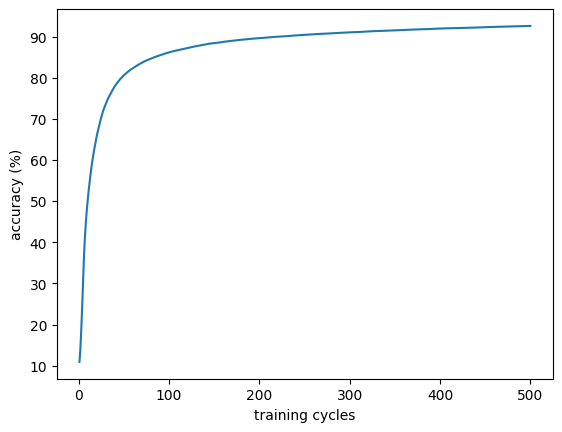

In [11]:
dimensions = [784, 128, 64, 10]

iterations = 500
rate = 0.05
model(img_data, one_hot_Y, dimensions, iterations, rate)